In [30]:
import pandas as pd
try:
    # Cargamos todas las hojas del archivo CSV
    excel_file_path = './data/data_lol.csv'
    all_sheets = pd.read_csv(excel_file_path)
    
    # Mostraremos las primeras filas de cada hoja para entender la estructura de los datos
    sheet_overview = {sheet_name: data.head() for sheet_name, data in all_sheets.items()}
except Exception as e:
    sheet_overview = str(e)

In [33]:
# Primero, calcularemos los promedios de 'blueKills' y 'blueExperienceDiff'
# y luego definiremos umbrales para categorizar las partidas.
kills_mean = all_sheets['blueKills'].mean()
kills_std = all_sheets['blueKills'].std()
exp_diff_mean = all_sheets['blueExperienceDiff'].mean()
exp_diff_std = all_sheets['blueExperienceDiff'].std()

# Definimos los umbrales para las categorías elegidas
thresholds = {
    'kills': {
        'Excelente': kills_mean + kills_std,
        'Medio': kills_mean,
        'Bajo': kills_mean - kills_std
    },
    
    'exp_diff': {
        'Excelente': exp_diff_mean + exp_diff_std,
        'Medio': exp_diff_mean,
        'Bajo': exp_diff_mean - exp_diff_std
    }
}

thresholds

{'kills': {'Excelente': 9.500145064992862,
  'Medio': 6.4675,
  'Bajo': 3.4348549350071376},
 'exp_diff': {'Excelente': 1904.335106393629,
  'Medio': 35.755,
  'Bajo': -1832.8251063936289}}

In [34]:
# Con los umbrales definidos, ahora podemos crear una nueva columna para etiquetar cada partida como 'excelente', 'bueno', o 'bien'.
# Usaremos los umbrales de 'blueGoldDiff' para categorizar las partidas.

# Función para etiquetar las partidas basado en la diferencia de oro
def categorize_match(kills, exp_diff, thresholds):
    if kills >= thresholds['kills']['Excelente'] or exp_diff >= thresholds['exp_diff']['Excelente']:
        return 'Excelente'
    elif kills <= thresholds['kills']['Bajo'] and exp_diff <= thresholds['exp_diff']['Bajo']:
        return 'Bajo'
    else:
        return 'Medio'
    
# Aplicamos la función para etiquetar cada partida
all_sheets['performance_category'] = all_sheets.apply(
    lambda row: categorize_match(row['blueKills'], row['blueExperienceDiff'], thresholds), axis=1
)

# Ahora tenemos una columna 'performance_category' con la clasificación de rendimiento de cada partida ganada'
performance_categories = all_sheets[['blueKills', 'blueExperienceDiff', 'performance_category']].head(10)
performance_categories

,blueKills,blueExperienceDiff,performance_category
0,6,2378,Excelente
1,3,-539,Medio
2,12,359,Excelente
3,4,-2052,Medio
4,7,-864,Medio
5,7,-139,Medio
6,6,2242,Excelente
7,4,-875,Medio
8,5,939,Medio
9,4,-3582,Medio


In [35]:
# Procederemos a aplicar los cuatro métodos de clasificación al conjunto de datos etiquetado.
# Primero, dividiremos los datos en conjuntos de entrenamiento y prueba.
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Preparamos los datos
X = all_sheets[['blueKills', 'blueExperienceDiff']]
y = all_sheets['performance_category']

# Codificamos las etiquetas de rendimiento
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

In [36]:
# Inicializamos los modelos
models = {
	'Logistic Regression': LogisticRegression(max_iter=200),
	'LDA': LinearDiscriminantAnalysis(),
	'Naive Bayes': GaussianNB(),
	'k-NN': KNeighborsClassifier(n_neighbors=5)
}

# Entrenamos los modelos y evaluamos su rendimiento
results = {}

for model_name, model in models.items():
    # Entrenamiento del modelo
    model.fit(X_train, y_train)
    # Predicción en el conjunto de prueba
    y_pred = model.predict(X_test)
    # Evaluación del modelo
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    # Almacenamiento de los resultados
    results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Report': report
    }

# Mostramos los resultados de precisión para cada modelo
for model_name, result in results.items():
    print(f"{model_name} Accuracy: {result['Accuracy']:.2f}")
    print(result['Report'])
    print("--------------------------------------------------\n")

Logistic Regression Accuracy: 0.94
              precision    recall  f1-score   support

        Bajo       0.75      1.00      0.86         3
   Excelente       0.87      0.87      0.87        15
       Medio       0.97      0.95      0.96        62

    accuracy                           0.94        80
   macro avg       0.86      0.94      0.89        80
weighted avg       0.94      0.94      0.94        80

--------------------------------------------------

LDA Accuracy: 0.94
              precision    recall  f1-score   support

        Bajo       0.75      1.00      0.86         3
   Excelente       0.87      0.87      0.87        15
       Medio       0.97      0.95      0.96        62

    accuracy                           0.94        80
   macro avg       0.86      0.94      0.89        80
weighted avg       0.94      0.94      0.94        80

--------------------------------------------------

Naive Bayes Accuracy: 0.94
              precision    recall  f1-score   support

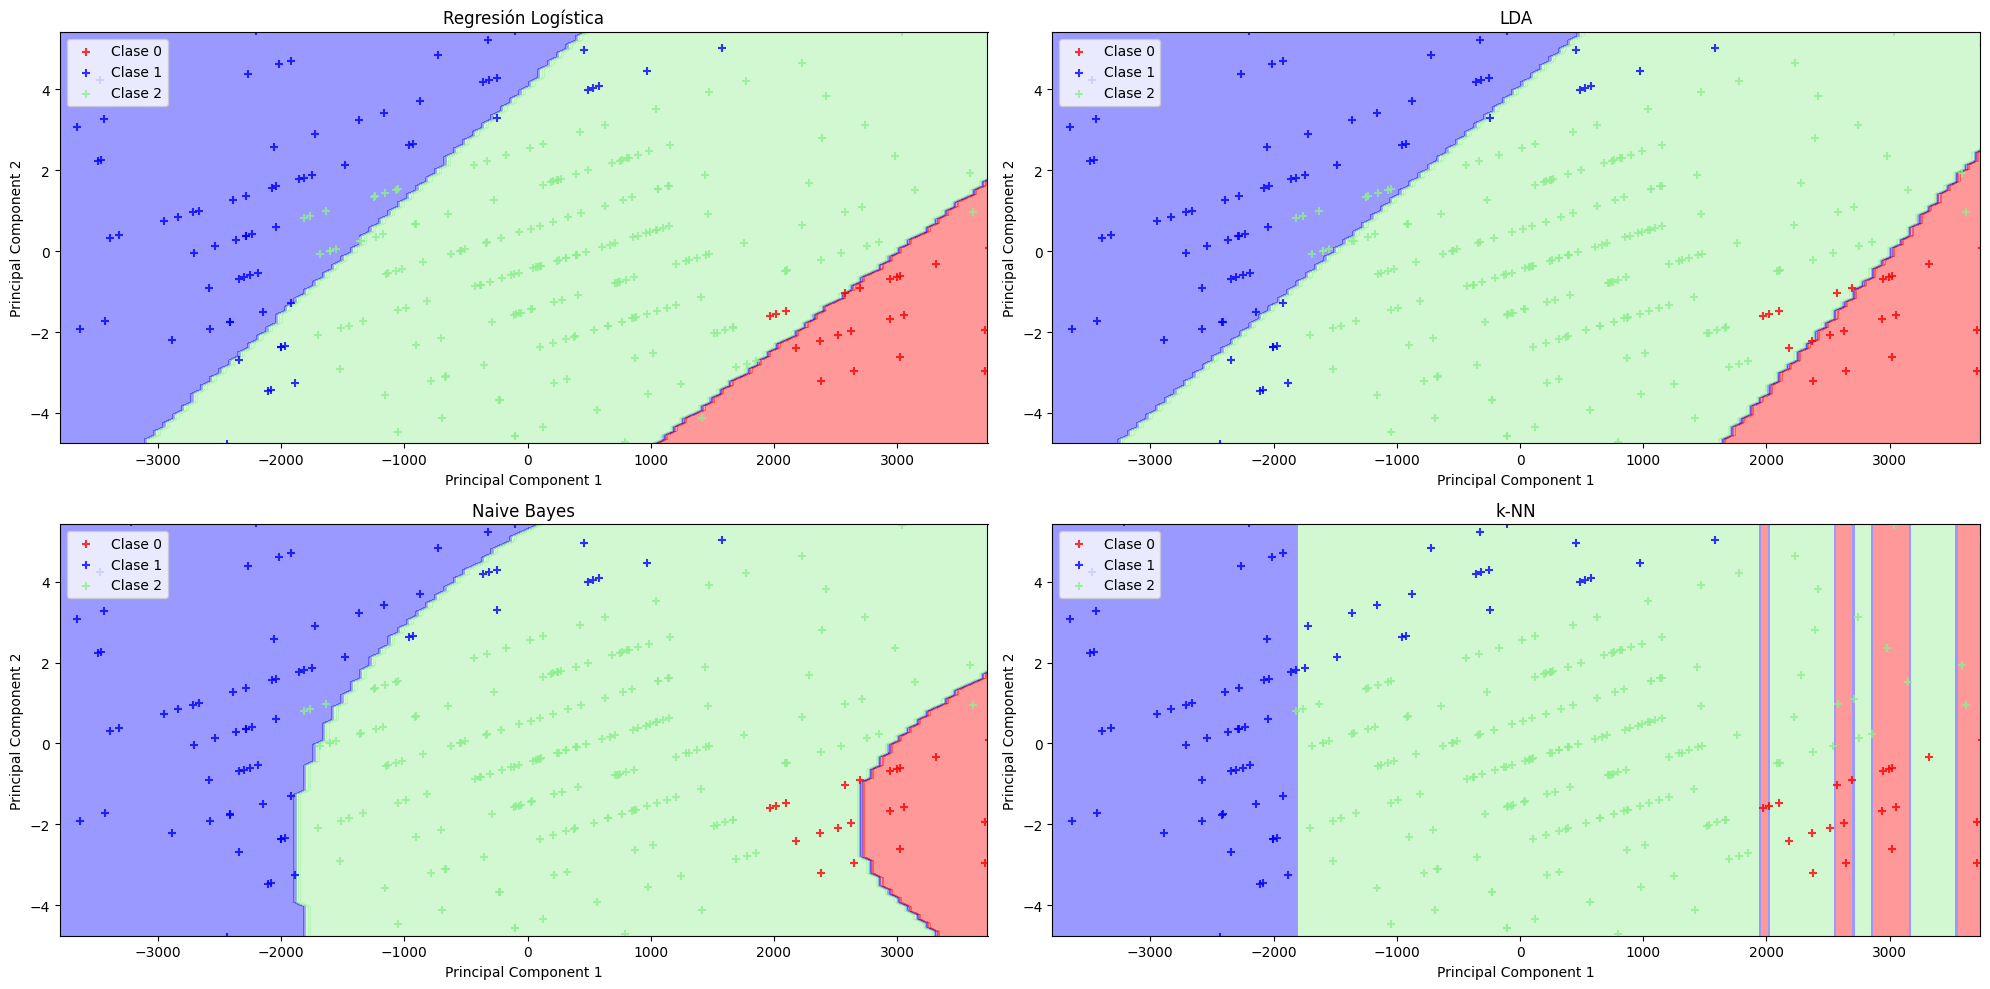

In [37]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Aplicamos PCA para reducir a dos dimensiones, aunque creo que no es necesario......
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

# esta parte mejor no la toquen
# print(X_r)
# print(X)

# Dividimos los datos proyectados en conjuntos de entrenamiento y prueba
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_encoded, test_size=0.2, random_state=0)

# Función para visualizar los límites de decisión en 2D
# Ajustamos la función para usar un rango más pequeño y un paso más grande para la malla
def plot_decision_boundaries_very_low_res(X, y, model, title):
    model.fit(X, y)
    # Definimos rangos para graficar con un paso más grande para reducir el rango de la malla
    x_min, x_max = np.percentile(X[:, 0], [2, 98])
    y_min, y_max = np.percentile(X[:, 1], [2, 98])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predecimos las clases para cada punto en la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Creamos mapa de colores
    colors = ('red', 'blue', 'lightgreen')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Dibujamos la malla de decision
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Graficamos los puntos de datos
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker='+', label=f'Clase {cl}')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper left')
    plt.title(title)

# Visualizamos los límites de decisión para cada modelo en los datos reducidos a 2D con muy baja resolución
plt.figure(figsize=(20, 10))

# Regresión Logística
plt.subplot(2, 2, 1)
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, LogisticRegression(max_iter=1000), "Regresión Logística")

# LDA
plt.subplot(2, 2, 2)
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, LinearDiscriminantAnalysis(), "LDA")

# Naive Bayes
plt.subplot(2, 2, 3)
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, GaussianNB(), "Naive Bayes")

# k-NN
plt.subplot(2, 2, 4)
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, KNeighborsClassifier(n_neighbors=5), "k-NN")

plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

y_pred_logistic = results['Logistic Regression']['Model'].predict(X_test_r)
logistic_model = results['Logistic Regression']['Model']

# Calculamos nuevamente las métricas de evaluación para el modelo de Regresión Logística
logistic_accuracy = accuracy_score(y_test_r, y_pred_logistic)
logistic_f1 = f1_score(y_test_r, y_pred_logistic, average='weighted')
logistic_cm = confusion_matrix(y_test_r, y_pred_logistic)
logistic_roc_auc = roc_auc_score(y_test_r, logistic_model.predict_proba(X_test_r), multi_class='ovr')

# Mostramos las métricas corregidas
logistic_metrics_corrected = {
    'Accuracy': logistic_accuracy,
    'F1 Score': logistic_f1,
    'Confusion Matrix': logistic_cm,
    'ROC AUC': logistic_roc_auc
}

logistic_metrics_corrected

c:\Users\lucia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\lucia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


{'Accuracy': 0.0125,
 'F1 Score': 0.007352941176470588,
 'Confusion Matrix': array([[ 0,  3,  0],
        [14,  1,  0],
        [30, 32,  0]], dtype=int64),
 'ROC AUC': 0.3476511899092545}

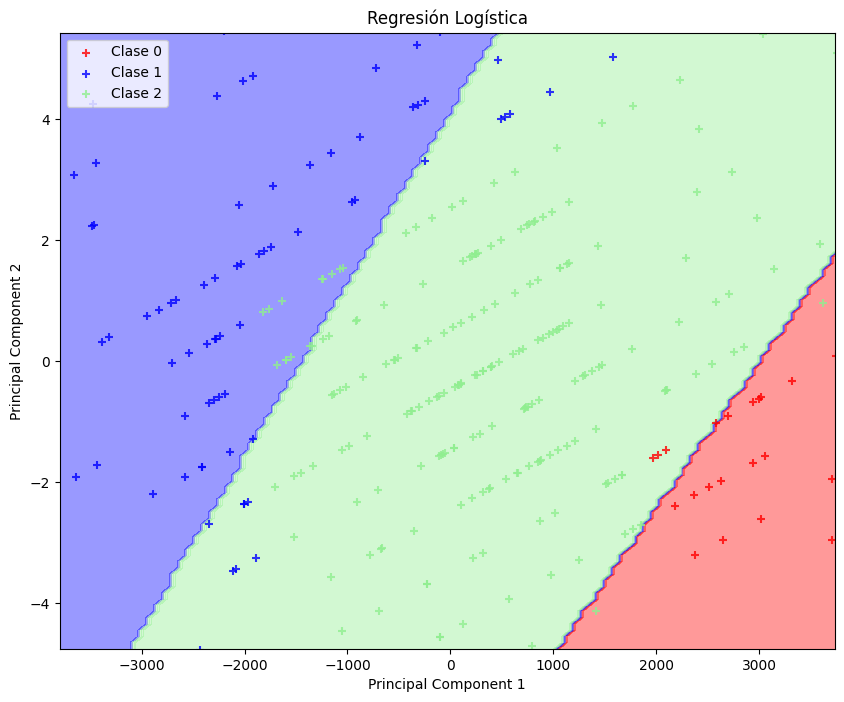

{'Accuracy': 0.9375,
 'F1 Score': 0.9381387921022067,
 'Confusion Matrix': array([[ 3,  0,  0],
        [ 0, 13,  2],
        [ 1,  2, 59]], dtype=int64),
 'ROC AUC': 0.9864222038415588}

In [39]:
## Visualizamos los límites de decisión para Regresión Logística en los datos reducidos a 2D
plt.figure(figsize=(10, 8))
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, LogisticRegression(max_iter=1000), "Regresión Logística")
plt.show()

# Además, calculamos las métricas para el modelo de Regresión Logística
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_r, y_train_r)
y_pred_logistic = logistic_model.predict(X_test_r)

# Calculamos las métricas de evaluación
logistic_accuracy = accuracy_score(y_test_r, y_pred_logistic)
logistic_f1 = f1_score(y_test_r, y_pred_logistic, average='weighted')
logistic_cm = confusion_matrix(y_test_r, y_pred_logistic)
logistic_roc_auc = roc_auc_score(y_test_r, logistic_model.predict_proba(X_test_r), multi_class='ovr')

# Mostramos las métricas
logistic_metrics = {
    'Accuracy': logistic_accuracy,
    'F1 Score': logistic_f1,
    'Confusion Matrix': logistic_cm,
    'ROC AUC': logistic_roc_auc
}



logistic_metrics

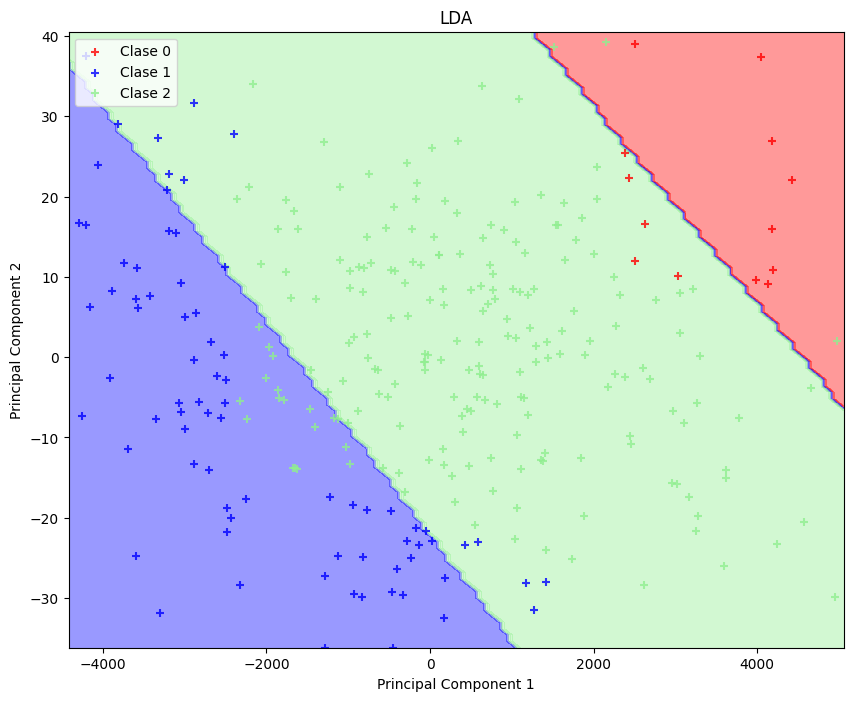

{'Accuracy': 0.85,
 'F1 Score': 0.8495448179271708,
 'Confusion Matrix': array([[ 3,  0,  0],
        [ 0, 20,  6],
        [ 1,  5, 45]], dtype=int64),
 'ROC AUC': 0.9430435402375904}

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Visualizamos los límites de decisión para LDA en los datos reducidos a 2D
plt.figure(figsize=(10, 8))
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, LinearDiscriminantAnalysis(), "LDA")
plt.show()


# Entrenamos y calculamos las métricas para el modelo de LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_r, y_train_r)
y_pred_lda = lda_model.predict(X_test_r)

# Calculamos las métricas de evaluación para LDA
lda_accuracy = accuracy_score(y_test_r, y_pred_lda)
lda_f1 = f1_score(y_test_r, y_pred_lda, average='weighted')
lda_cm = confusion_matrix(y_test_r, y_pred_lda)
lda_roc_auc = roc_auc_score(y_test_r, lda_model.predict_proba(X_test_r), multi_class='ovr')

# Mostramos las métricas para LDA
lda_metrics = {
    'Accuracy': lda_accuracy,
    'F1 Score': lda_f1,
    'Confusion Matrix': lda_cm,
    'ROC AUC': lda_roc_auc
}

lda_metrics

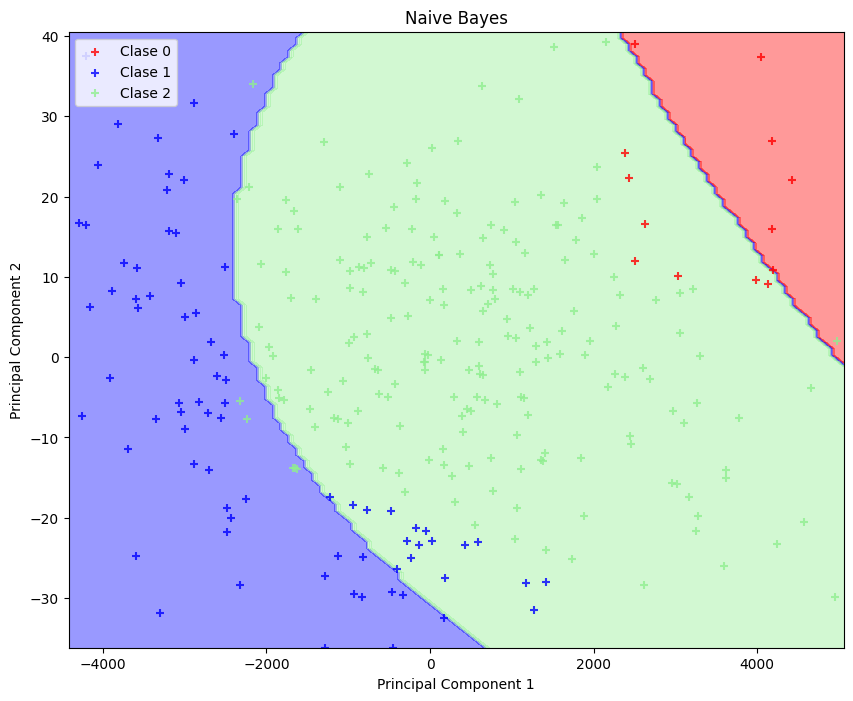

{'Accuracy': 0.9125,
 'F1 Score': 0.9123176144244105,
 'Confusion Matrix': array([[ 3,  0,  0],
        [ 0, 22,  4],
        [ 1,  2, 48]], dtype=int64),
 'ROC AUC': 0.9868886153537945}

In [28]:
from sklearn.naive_bayes import GaussianNB

# Visualizamos los límites de decisión para Naive Bayes en los datos reducidos a 2D
plt.figure(figsize=(10, 8))
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, GaussianNB(), "Naive Bayes")
plt.show()

# Entrenamos y calculamos las métricas para el modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_r, y_train_r)
y_pred_nb = nb_model.predict(X_test_r)

# Calculamos las métricas de evaluación para Naive Bayes
nb_accuracy = accuracy_score(y_test_r, y_pred_nb)
nb_f1 = f1_score(y_test_r, y_pred_nb, average='weighted')
nb_cm = confusion_matrix(y_test_r, y_pred_nb)
nb_roc_auc = roc_auc_score(y_test_r, nb_model.predict_proba(X_test_r), multi_class='ovr')

# Mostramos las métricas para Naive Bayes
nb_metrics = {
    'Accuracy': nb_accuracy,
    'F1 Score': nb_f1,
    'Confusion Matrix': nb_cm,
    'ROC AUC': nb_roc_auc
}

nb_metrics


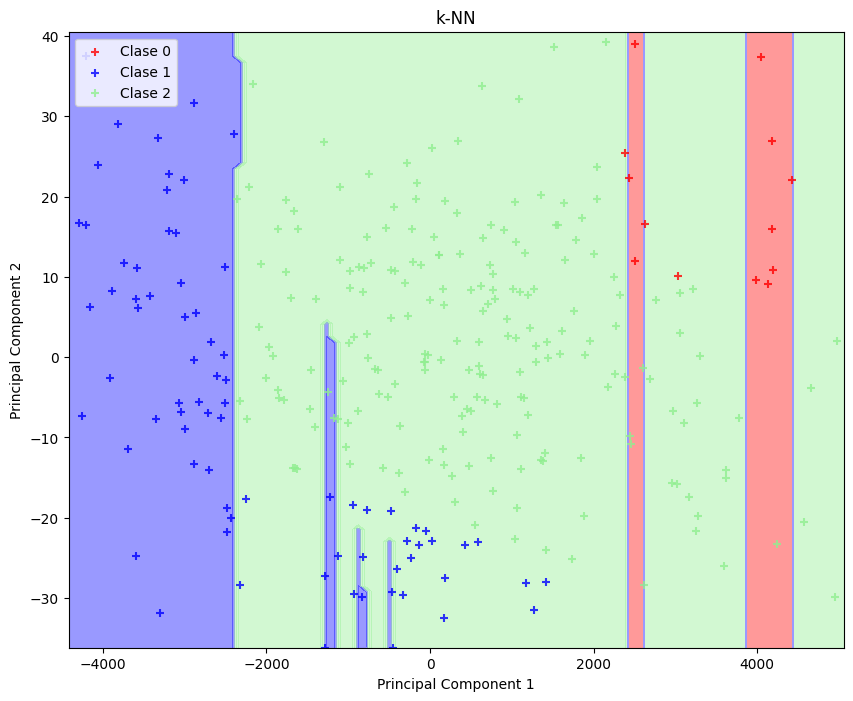

{'Accuracy': 0.7875,
 'F1 Score': 0.7870447429136453,
 'Confusion Matrix': array([[ 1,  0,  2],
        [ 0, 15, 11],
        [ 4,  0, 47]], dtype=int64),
 'ROC AUC': 0.8194815539305059}

In [29]:
from sklearn.neighbors import KNeighborsClassifier

# Visualizamos los límites de decisión para k-NN en los datos reducidos a 2D
plt.figure(figsize=(10, 8))
plot_decision_boundaries_very_low_res(X_train_r, y_train_r, KNeighborsClassifier(n_neighbors=5), "k-NN")
plt.show()

# Entrenamos y calculamos las métricas para el modelo k-NN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_r, y_train_r)
y_pred_knn = knn_model.predict(X_test_r)

# Calculamos las métricas de evaluación para k-NN
knn_accuracy = accuracy_score(y_test_r, y_pred_knn)
knn_f1 = f1_score(y_test_r, y_pred_knn, average='weighted')
knn_cm = confusion_matrix(y_test_r, y_pred_knn)
knn_roc_auc = roc_auc_score(y_test_r, knn_model.predict_proba(X_test_r), multi_class='ovr')

# Mostramos las métricas para k-NN
knn_metrics = {
    'Accuracy': knn_accuracy,
    'F1 Score': knn_f1,
    'Confusion Matrix': knn_cm,
    'ROC AUC': knn_roc_auc
}

knn_metrics
